# **CIFAR-10 image classification**

### Load, pre-process and explore data

In [1]:
# Import libraries
import json 
from pprint import pprint
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
# Load data
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.49139968,0.48215841,0.44653091), (0.24703223,0.24348513,0.26158784)),
])

transform_test = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize((0.49139968,0.48215841,0.44653091), (0.24703223,0.24348513,0.26158784)),
                                     ])

batch_size=32
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
train_dataloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size , shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
val_dataloader = torch.utils.data.DataLoader(testset, batch_size= batch_size, shuffle=False)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [3]:
# Check shape
print("train data shape:", trainset.data.shape)
print("test data shape:",testset.data.shape)

train data shape: (50000, 32, 32, 3)
test data shape: (10000, 32, 32, 3)


In [4]:
# Label dictionary
label_dict = {0:"airplane",1:"automobile",2:"bird",3:"cat",4:"deer",5:"dog",6:"frog",7:"horse",8:"ship",9:"truck"}

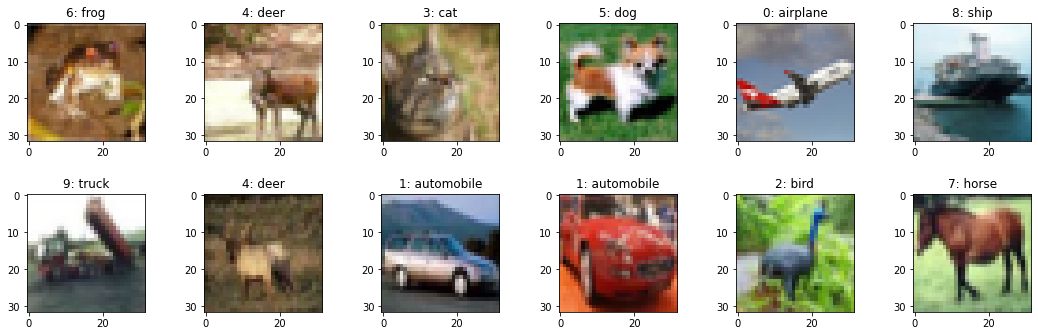

In [5]:
# Plot random images
image_idx = [0,1001,3550,12310,31674,42763,2,3,4,5,6,7]
fig = plt.figure(figsize=(18,6))
fig.subplots_adjust(hspace=0.1, wspace=0.5)

for i in range(len(image_idx)):
  img_index = image_idx[i]
  # Load image at index img_index
  rgb_img = trainset.data[img_index]
  rgb_img = rgb_img.astype('float32')    
  rgb_img/= 255.0

  # Plot
  ax = fig.add_subplot(2, 6, i+1)
  ax = plt.imshow(rgb_img)
  ax = plt.title(f'{trainset.targets[img_index]}: {label_dict[trainset.targets[img_index]]}')

### Set up & functions

In [9]:
# Connect to drive to save models
from google.colab import drive
drive.mount('/content/gdrive')
!pwd

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content


In [7]:
# Set up GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if torch.cuda.is_available():
  device = "cuda"
else:
  device = "cpu"
print(f"Using {device}.")
if gpu_info.find('failed') >= 0:
  if device == "cpu":
    print('Not connected to a GPU')
else:
  if device == "cuda":
    print(gpu_info)

Using cuda.
Sun Jan 29 16:44:31 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    25W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                            

In [20]:
def train_validate_model(train_loader,valid_loader,model,epochs,optimizer, save_pth):
  '''
  Input: train & validation data, model and its parameters, path to save model
  Output: - the model is trained and validated on the provided data
          - training & validation accuracy & loss are recorded and returned as output
  '''
  train_acc = []
  train_loss = []
  val_acc = []
  val_loss = []

  for epoch in range(epochs):
      # Training
      total_train=0
      correct_train = 0
      for i, (images, labels) in enumerate(train_loader):  
          # Move tensors to the configured device
          images = images.to(device)
          labels = labels.to(device)
          # Forward pass
          outputs = model(images)
          loss = criterion(outputs, labels)
          # Backward and optimize
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          # Calculate train accuracy
          _, predicted = torch.max(outputs.data, 1)
          total_train += labels.size(0)
          correct_train += (predicted == labels).sum().item()
          del images, labels, outputs
      # Record accuracy & loss
      train_loss.append(loss.item())
      train_acc.append(100 * correct_train / total_train)
      print ('Epoch [{}/{}], Loss: {:.4f}, Train accuracy: {}' 
                   .format(epoch+1, epochs, loss.item(),100 * correct_train / total_train))
            
      # Validation
      with torch.no_grad():
          correct_val = 0
          total_val = 0
          for images, labels in valid_loader:
              # Move tensors to the configured device
              images = images.to(device)
              labels = labels.to(device)
              # Predict label
              outputs = model(images)
              # Calculate loss & accuracy
              loss=criterion(outputs, labels)
              _, predicted = torch.max(outputs.data, 1)
              total_val += labels.size(0)
              correct_val += (predicted == labels).sum().item()
              del images, labels, outputs
          # Record accuracy & loss
          val_loss.append(loss.item())
          val_acc.append(100 * correct_val / total_val)
          print('Loss: {:.4f}, Validation accuracy: {} %'.format(loss.item(), 100 * correct_val / total_val))
      # Save model by epoch 
      torch.save(model.state_dict(), f'{save_pth}/{epoch+1}epoch.pt')

  return train_acc, train_loss, val_acc, val_loss

In [33]:
def plot_acc_loss(epoch_list, train_acc, train_loss, val_acc, val_loss):
  '''
  Input: list of epoch number, list of training & validation accuracy & loss
  Output: 2 graphs of loss and accuracy by epoch and train/validation
  '''
  f, (ax1, ax2) = plt.subplots(1,2,figsize=(15, 5))
  # Plot loss graph
  ax1.plot(epoch_list, train_loss, label = "Train losses by epoch")
  ax1.plot(epoch_list, val_loss, label = "Validation losses by epoch")
  ax1.set_xlabel("Epoch")
  ax1.set_ylabel("Cross entrophy loss")
  ax1.legend()
  # Plot accuracy graph
  ax2.plot(epoch_list, train_acc, label = "Train accuracy by epoch")
  ax2.plot(epoch_list, val_acc, label = "Validation accuracy by epoch")
  ax2.set_xlabel("Epoch")
  ax2.set_ylabel("Accuracy score")
  ax2.legend()

### 1. VGG16

In [37]:
# Define VGG16 network
class VGG16(nn.Module):
    def __init__(self,num_classes=10):
        super(VGG16, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer8 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer9 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer10 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer11 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer12 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer13 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(1*1*512, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out) # 16x16
        out = self.layer3(out)
        out = self.layer4(out) # 8x8
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out) # 4x4
        out = self.layer8(out)
        out = self.layer9(out)
        out = self.layer10(out) # 2x2
        out = self.layer11(out)
        out = self.layer12(out)
        out = self.layer13(out) # 1x1
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [40]:
# Define model parameters
lr = 0.001
epochs = 15
model = VGG16(10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum = 0.9)
save_path = 'gdrive/MyDrive/Portfolio/CIFAR-10 image classification/VGG16'

In [41]:
# Train the model
vgg16_train_acc, vgg16_train_loss, vgg16_val_acc, vgg16_val_loss = train_validate_model(train_dataloader,val_dataloader,model,epochs,optimizer, save_path)

Epoch [1/15], Loss: 0.9568, Train accuracy: 49.014
Loss: 1.0215, Validation accuracy: 64.33 %
Epoch [2/15], Loss: 0.6904, Train accuracy: 70.464
Loss: 1.0359, Validation accuracy: 73.99 %
Epoch [3/15], Loss: 0.7710, Train accuracy: 78.33
Loss: 1.3009, Validation accuracy: 76.32 %
Epoch [4/15], Loss: 0.3356, Train accuracy: 83.39
Loss: 0.8442, Validation accuracy: 79.13 %
Epoch [5/15], Loss: 0.3401, Train accuracy: 86.816
Loss: 1.0174, Validation accuracy: 80.78 %
Epoch [6/15], Loss: 0.4441, Train accuracy: 89.544
Loss: 1.1195, Validation accuracy: 80.14 %
Epoch [7/15], Loss: 0.1811, Train accuracy: 91.53
Loss: 0.6870, Validation accuracy: 80.95 %
Epoch [8/15], Loss: 0.0869, Train accuracy: 93.258
Loss: 1.1686, Validation accuracy: 81.76 %
Epoch [9/15], Loss: 0.0444, Train accuracy: 94.574
Loss: 0.8731, Validation accuracy: 82.15 %
Epoch [10/15], Loss: 0.0993, Train accuracy: 95.704
Loss: 0.7343, Validation accuracy: 81.27 %
Epoch [11/15], Loss: 0.4986, Train accuracy: 96.196
Loss: 1.86

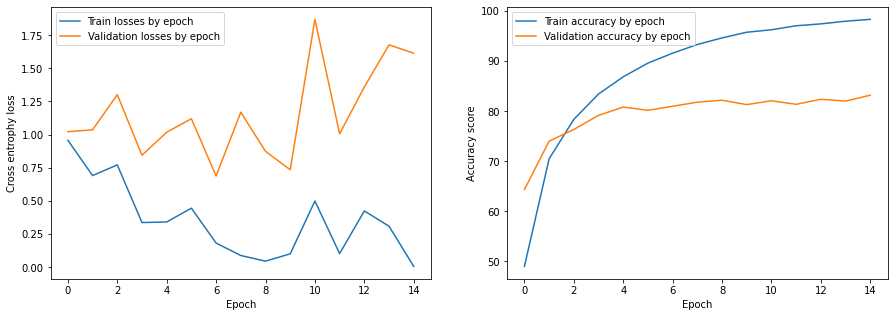

In [42]:
# Plot loss and accuracy plot
epoch_list = []
for epoch in range(epochs):
  epoch_list.append(epoch)

plot_acc_loss(epoch_list, vgg16_train_acc, vgg16_train_loss, vgg16_val_acc, vgg16_val_loss)

In [ ]:
# Parameters to tune